# Dealing with numerical instability

Internally, the FRAGMENT-MNP model uses a [numerical solver](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to solve an initial value problem for the [system of ODEs that form the model](https://microplastics-cluster.github.io/fragment-mnp/developers/api.html#fragment-mnp-model).

For certain input parameter ranges, care needs to be taken to avoid the solution becoming unstable. This is particularly relevant when mass concentrations in a certain size class trend asymptotically towards zero, in which case the system can be described as ["stiff"](https://en.wikipedia.org/wiki/Stiff_equation). The model provides a few ways of dealing with this:
* Changing the integration method used by specifying the [`solver_method`](config:solver_method) config option. The available methods are those [provided by SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). "Radau", "BDF" and "LSODA" are particularly well suited to stiff problems.
* Changing the max step size by specifying the [`solver_max_step`](config:solver_max_step) config option.
* Changing the error tolerances by specifying the [`solver_rtol` and `solver_atol`](config:solver_rtol_atol) config options.

## Example of a numerically unstable problem

Let's create a model setup that will be numerically unstable. We do this by setting a relatively high dissolution rate $k_\text{diss}$. First, let's use the [Runge-Kutta order 5(4)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.RK45.html) solver (RK45), which is an explicit solver and therefore not particularly good at dealing with stiff problems. This is the default option, and so we don't need to specify it explicitly as a config option.

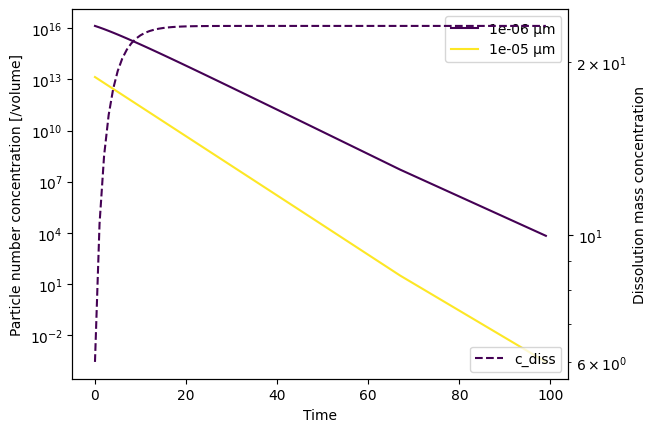

In [18]:
import numpy as np
from fragmentmnp import FragmentMNP
from fragmentmnp.examples import minimal_config, minimal_data

# Keeping it simply with two size classes
minimal_config['n_size_classes'] = 2
minimal_config['particle_size_range'] = [-6, -5]

# Arbitrary initial concs and a high dissolution rate
minimal_data['initial_concs'] = [10, 10]
minimal_data['k_frag'] = 0.1
minimal_data['k_diss'] = 0.3

# Run the model and plot the output
fmnp = FragmentMNP(minimal_config, minimal_data)
output = fmnp.run()
fig, axs = output.plot(plot_dissolution=True, log_yaxis=True)


Something is clearly going wrong here! Let's try [LSODA](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.LSODA.html) instead, which is better at dealing with stiffness:

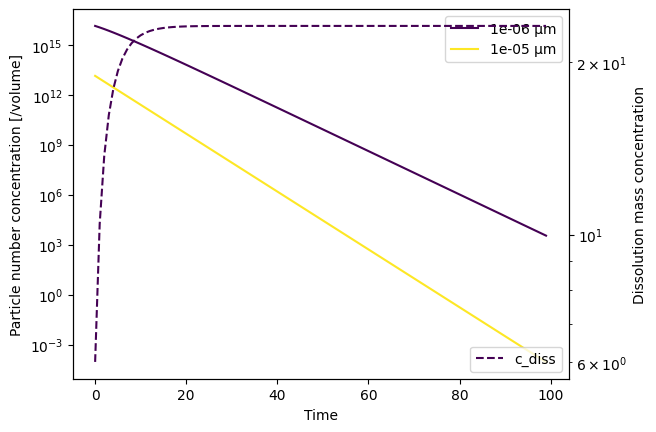

In [34]:
# Set the solver method to LSODA, which is particularly suited
# to dealing with stiff problems
minimal_config['solver_method'] = 'LSODA'

fmnp = FragmentMNP(minimal_config, minimal_data)
output = fmnp.run()
fig, axs = output.plot(plot_dissolution=True, log_yaxis=True)

Better, but not quite there yet. If we look at the SciPy solution object, accessed via `output.soln`, we can see the number of evaluations made (`nfev`):

In [20]:
output.soln.nfev

349

Let's try and set a smaller `solver_max_step` and thereby increase this number of evaluations, to see if that helps:

785

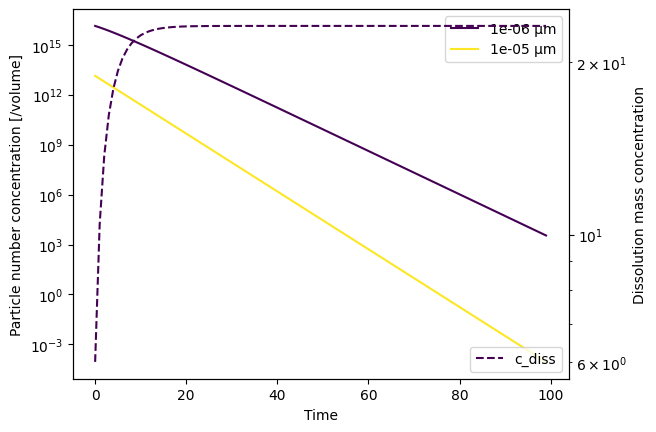

In [35]:
# Set the maximum step size (i.e. timestep) for the ODE solver
minimal_config['solver_max_step'] = 0.3

fmnp = FragmentMNP(minimal_config, minimal_data)
output = fmnp.run()
fig, axs = output.plot(plot_dissolution=True, log_yaxis=True)
output.soln.nfev

This seems to have done the trick! Alternatively, we could have set smaller `atol` and `rtol` than the defaults (10e-6 and 10e-3, respectively):

543

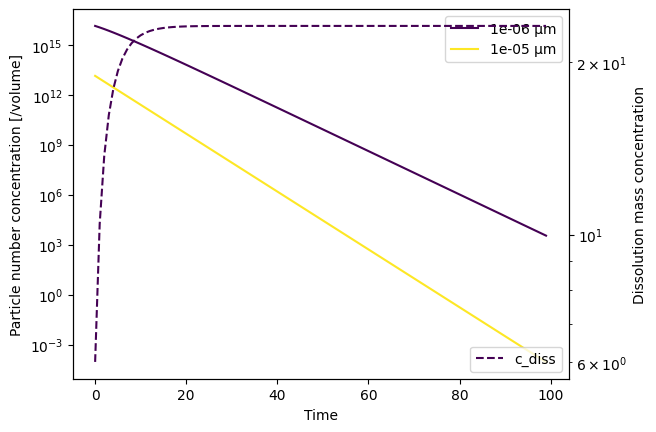

In [36]:
# Don't set a max step size, but set small error tolerances instead
minimal_config['solver_max_step'] = np.inf
minimal_config['solver_atol'] = 10e-14
minimal_config['solver_rtol'] = 10e-12

fmnp = FragmentMNP(minimal_config, minimal_data)
output = fmnp.run()
fig, axs = output.plot(plot_dissolution=True, log_yaxis=True)
output.soln.nfev


Note that we have to set considerably smaller tolerances than the defaults to solve the instability.